<a href="https://githubtocolab.com/alsinmr/ConferenceExamples/blob/master/Windischleuba2023/scalarPRE.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

# Paramagnetic Relaxation Enhancement: Scalar Relaxation

In [ ]:
!git clone https://github.com/alsinmr/ConferenceExamples.git
%cd /content/ConferenceExamples/GNMR2023
import setup

In [ ]:
#Sometimes, there is a delay between setup finishing and being able to complete the module loads
from importlib.machinery import SourceFileLoader #Why do I need to use this instead of a simple import?
RS = SourceFileLoader("pyRelaxSim", "/content/pyRelaxSim/__init__.py").load_module()  
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [1]:
# #This cell is only for testing on my computer
# import sys
# sys.path.append('/Users/albertsmith/Documents/GitHub')
# sys.path.append('/Users/albertsmith/Documents/GitHub.nosync')
# import SLEEPY as RS
# import numpy as np
# import matplotlib.pyplot as plt

In [3]:
# %matplotlib notebook

## Part 1: Relaxation via exchange

We start by building the spin-system  with a $^{13}$C and an electron. In the first set of examples, relaxation will be induced by a scalar coupling that varies in magnitude, so we need two copies of the System/Experiment object with different values of the hyperfine coupling

In [2]:
ex0=RS.ExpSys(v0H=600,Nucs=['13C','e-'],LF=True)     #1-spin system at 600 MHz (14.1 T). LF=True : Lab Frame
ex1=ex0.copy()
aiso=2.5e6
ex0.set_inter(Type='hyperfine',i0=0,i1=1,Axx=aiso,Ayy=aiso,Azz=aiso)    #Hyperfine coupling
ex1.set_inter(Type='hyperfine',i0=0,i1=1,Axx=-aiso,Ayy=-aiso,Azz=-aiso)    #Hyperfine coupling

In [3]:
ex0.v0/1e9

array([ 1.50902297e-01, -3.94926366e+02])

Below, we create the Liouvillian, add an exchange matrix to it, and generator a propagator for 100 ms

In [4]:
L=RS.Liouvillian((ex0,ex1))
tc=1e-12     #Correlation time
p1=0.5  #Population of state 1

L.kex=RS.Tools.twoSite_kex(tc=tc,p1=p1)
U=L.U(Dt=.0005) #Propagator for 100 ms
_=U.eig()

We investigate the impact of the exchange of the isotropic (scalar) hyperfine coupling on the $^{13}$C magnetization

<AxesSubplot:xlabel='$t$ / ms', ylabel='<Op>'>

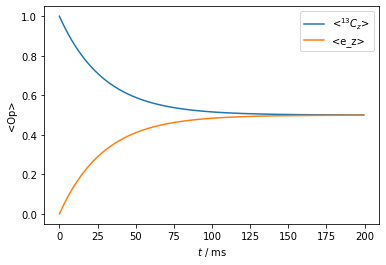

In [7]:
rho=RS.Rho(rho0='13Cz',detect=['13Cz','ez'])
rho.DetProp(U,n=400)
rho.plot(axis='ms')

We note that the action of the $T_{00}^{IS}$ operator on $I_z$ magnetization is to produce a difference term, $(I_z-S_z)$. We know this from the following commutators:
\begin{eqnarray}
\left[T_{00},\left[-\frac1{\sqrt3}I_zS_z,I_z\right]\right]&=&0 \\
\left[T_{00},\left[-\frac1{2\sqrt3}I^-S^+,I_z\right]\right]&=&\frac1{12}(I_z-S_z)\\
\left[T_{00},\left[-\frac1{2\sqrt3}I^+S^-,I_z\right]\right]&=&\frac1{12}(I_z-S_z)
\end{eqnarray}
Then, the expected result is an Overhauser effect, i.e. a transfer of magnetization from the polarized spin to the unpolarized spin. Indeed, this is what we observe for the longitudinal $^{13}$C magnetization, which then transfers to the electron.

The resulting expressions for $T_1$ and Overhauser effect are:
\begin{eqnarray}
\Gamma_{I_z,I_z}^{(IS)}&=&\frac{S(S+1)}{3}(2\pi J^{(IS)})J_0^X(\omega_I-\omega_S) \\
\Gamma_{S_z,I_z}^{(IS)}&=&-\frac{S(S+1)}{3}(2\pi J^{(IS)})J_0^X(\omega_I-\omega_S) \\
\end{eqnarray}

We next investigate the dependence of the $T_1$ on correlation time

<IPython.core.display.Javascript object>


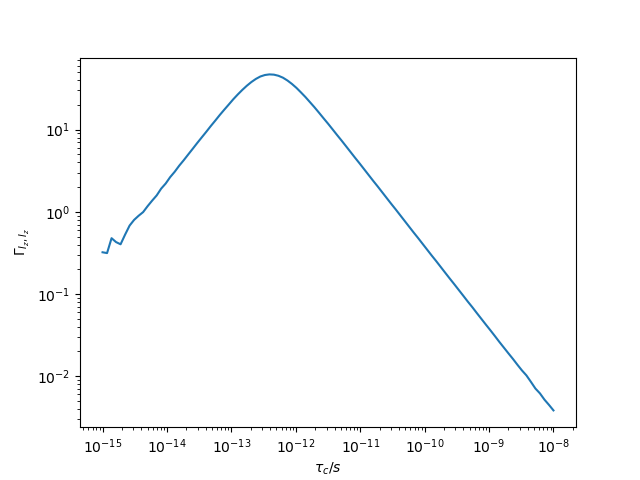

Text(0, 0.5, '$\\Gamma_{I_z,I_z}$')

In [10]:
tc0=np.logspace(-15,-8,101)
L.clear_relax()
R2=list()
Dt=.05

for k,tc in enumerate(tc0):
    rho.clear()
    L.kex=RS.Tools.twoSite_kex(tc=tc)
    U=L.U(Dt=Dt)
    rho.DetProp(U,n=4000)
    
    i0=np.abs(rho.I[0])<0.95
    if np.any(i0):
        i=np.argwhere(i0)[0,0]
        Dt=rho.t_axis[i]/10
    else:
        i=3999
        Dt*=10
    R2.append((1-np.abs(rho.I[0][i]))/rho.t_axis[i]*2)

ax=plt.subplots(1,1)[1]
ax.loglog(tc0,np.array(R2))
ax.set_xlabel(r'$\tau_c / s$')
ax.set_ylabel(r'$\Gamma_{I_z,I_z}$')

We see that the maximum relaxation rate occurs approximately at the inverse of the electron Larmor frequence, $1/\omega_{0e}$, or ~400 fs. 

In the next step, we investigate the impact of modulation of the scalar coupling on transverse $^{13}$C magnetization

<IPython.core.display.Javascript object>


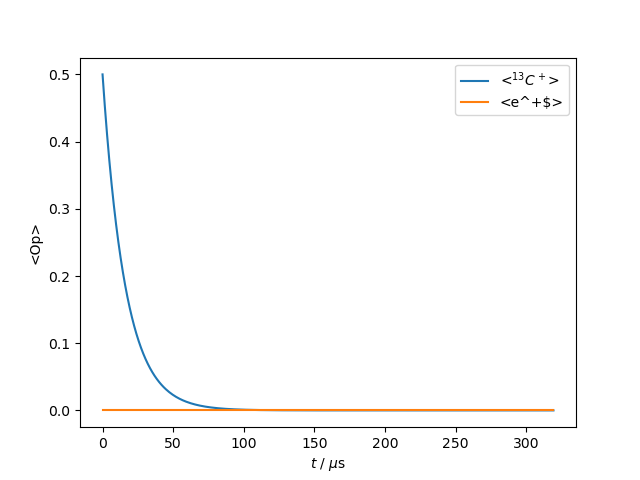

<AxesSubplot:xlabel='$t$ / $\\mu$s', ylabel='<Op>'>

In [11]:
L.kex=RS.Tools.twoSite_kex(tc=1e-9)
U=L.U(Dt=2/aiso)  #Sample such that we back fold the hyperfine to one line
rho=RS.Rho(rho0='13Cx',detect=['13Cp','ep'])
rho.DetProp(U,n=400)
rho.downmix()
rho.plot(axis='microseconds',mode='abs')

The action of the $T_{00}^{IS}$ operator on $I^+$ magnetization is to produce a difference term, $(I^+-S^+)$, as seen from the following commutators
\begin{eqnarray}
\left[T_{00},\left[-\frac1{\sqrt3}I_zS_z,I^+\right]\right]&=&\frac1{12}(I^+-S^+) \\
\left[T_{00},\left[-\frac1{2\sqrt3}I^-S^+,I^+\right]\right]&=&\frac1{12}(I^+-S^+)\\
\left[T_{00},\left[-\frac1{2\sqrt3}I^+S^-,I^+\right]\right]&=&0
\end{eqnarray}
The double commutators acting on $I^+$ yields $I^+-S^+$, although we do not observe buildup on the electron. The difference in Larmor frequencies prevents any net gain on the electrons despite the appearance of this term in the commutator.

The resulting formulas for the transverse relaxation are:
\begin{eqnarray}
\Gamma_{I^+,I^+}^{(IS)}&=&\frac{S(S+1)}{6}(2\pi J^{(IS)})(J_0^Z(0)+J_0^X(\omega_I-\omega_S)) \\
\Gamma_{S^+,I^+}^{(IS)}&=&-\frac{S(S+1)}{6}(2\pi J^{(IS)})(J_0^Z(0)+J_0^X(\omega_I-\omega_S))
\end{eqnarray}
Note the latter formula implies that the magnetization is transferred between the two spins. However, only if the two spins have the same Larmor frequency will the magnetization build up on the second spin, which is clearly not the case for the electron.

Next, we investigate the relaxation behavior as a function of $\tau_c$

<IPython.core.display.Javascript object>


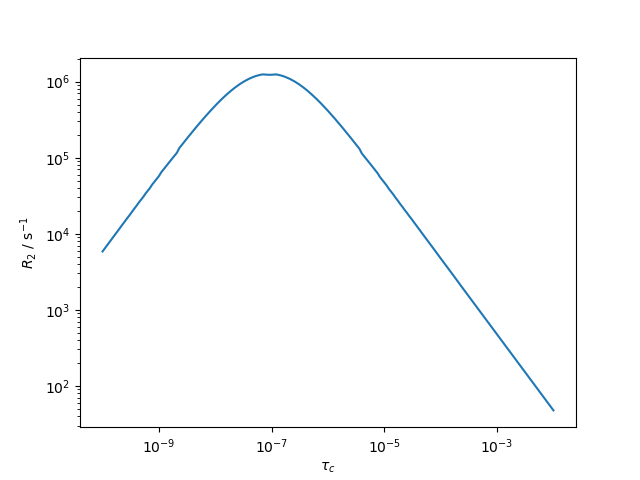

In [12]:
tc0=np.logspace(-10,-2,201)
R2=list()
rho=RS.Rho(rho0='13Cx',detect='13Cp')
# ax=plt.subplots(1,1)[1]

N=1

for k,tc in enumerate(tc0):
    rho.clear()
    L.kex=RS.Tools.twoSite_kex(tc=tc)
    U=L.U(Dt=2/aiso)**N
#     (U*rho)()
    rho.DetProp(U,n=4000)
    rho.downmix()
    
    i0=np.abs(rho.I[0])<0.45
    if np.any(i0):
        i=np.argwhere(i0)[0,0]
        N=max(1,int(rho.t_axis[i]/(2/aiso)/10))
    else:
        i=3999
        N*=10
    R2.append((0.5-np.abs(rho.I[0][i]))/rho.t_axis[i]*2)
ax=plt.subplots(1,1)[1]
ax.loglog(tc0,R2)
ax.set_xlabel(r'$\tau_c$')
_=ax.set_ylabel(r'$R_2$ / s$^{-1}$')

Then, the relaxation rate constants become continuously faster up until the correlation time is comparable to the size of the hyperfine coupling. At this stage, the formulas are no longer valid and the relaxation rate constants decrease.

## Part 2: Relaxation due to electron $T_1$ and $T_2$ relaxation 

In this case, we only require one experimental system, but we will add $T_1$ and $T_2$ relaxation to the Liouvillian

In [30]:
ex0=RS.ExpSys(v0H=600,Nucs=['13C','e-'],LF=True)     #1-spin system at 600 MHz (14.1 T). LF=True : Lab Frame
aiso=5e5
ex0.set_inter(Type='hyperfine',i0=0,i1=1,Axx=aiso,Ayy=aiso,Azz=aiso)    #Hyperfine coupling

L=RS.Liouvillian(ex0)
L.add_relax(Type='T2',i=1,T2=1e-12)
U=L.U(Dt=0.1)

### Relaxation induced by electron $T_2$ relaxation

In the first test, we investigate whether an electron $T_2$ alone can indeed introduce relaxation to the nucleus.

<IPython.core.display.Javascript object>


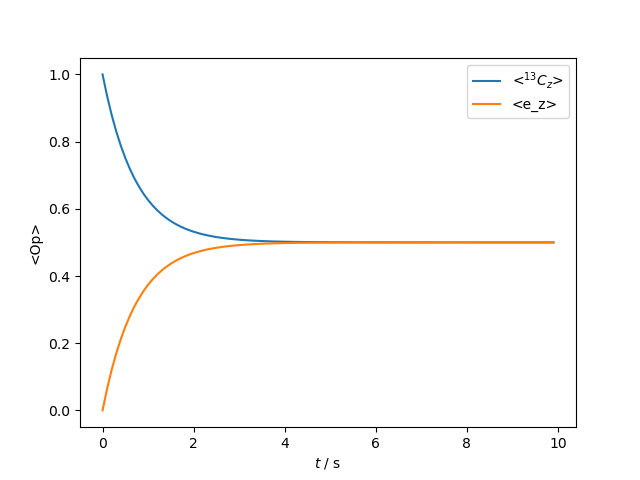

In [32]:
rho=RS.Rho(rho0='13Cz',detect=['13Cz','ez'])
rho.DetProp(U,n=100)
_=rho.plot(axis='s')

Indeed, the electron $T_2$ alone can induce Overhauser effect between the electron and nucleus. This is a result of the commutators:
\begin{eqnarray}
\left[T_{00},\left[-\frac1{2\sqrt3}I^-S^+,I_z\right]\right]&=&\frac1{12}(I_z-S_z)\\
\left[T_{00},\left[-\frac1{2\sqrt3}I^+S^-,I_z\right]\right]&=&\frac1{12}(I_z-S_z)
\end{eqnarray}
Where the terms $I^-S^+$ and $I^+S^-$ are modulated by the electron $T_2$

<IPython.core.display.Javascript object>


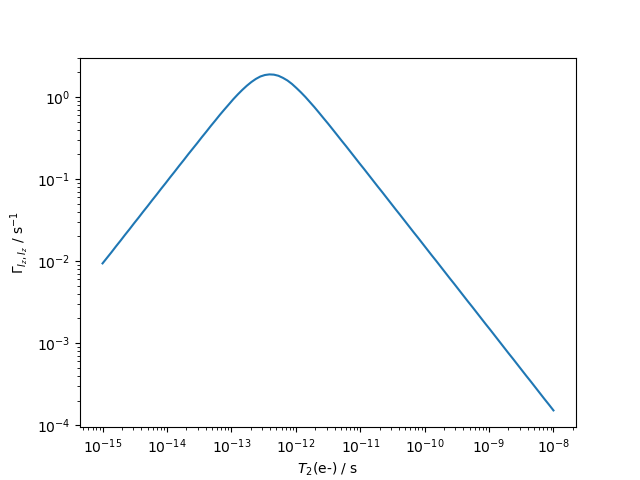

In [24]:
T20=np.logspace(-15,-8,101)

R2=list()
Dt=.1
for k,T2 in enumerate(T20):
    rho.clear()
    L.clear_relax()
    L.add_relax(Type='T2',i=1,T2=T2)
    U=L.U(Dt=Dt)
    rho.DetProp(U,n=4000)
    
    i0=np.abs(rho.I[0])<0.95
    if np.any(i0):
        i=np.argwhere(i0)[0,0]
        Dt=rho.t_axis[i]/10
    else:
        i=3999
        Dt*=10
    R2.append((1-np.abs(rho.I[0][i]))/rho.t_axis[i]*2)

ax=plt.subplots(1,1)[1]
ax.loglog(T20,np.array(R2))
ax.set_xlabel(r'$T_2$(e-) / s')
_=ax.set_ylabel(r'$\Gamma_{I_z,I_z}}$ / s$^{-1}$')

The $T_2$ relaxation should only modulate the $I^+S^-$ and $I^-S^+$ terms. Due to the commutors:
\begin{eqnarray}
\left[T_{00},\left[-\frac1{2\sqrt3}I^-S^+,I^+\right]\right]&=&\frac1{12}(I^+-S^+)\\
\left[T_{00},\left[-\frac1{2\sqrt3}I^+S^-,I^+\right]\right]&=&0
\end{eqnarray}
we expect that there should be $T_2$ relaxation on the nucleus

<IPython.core.display.Javascript object>


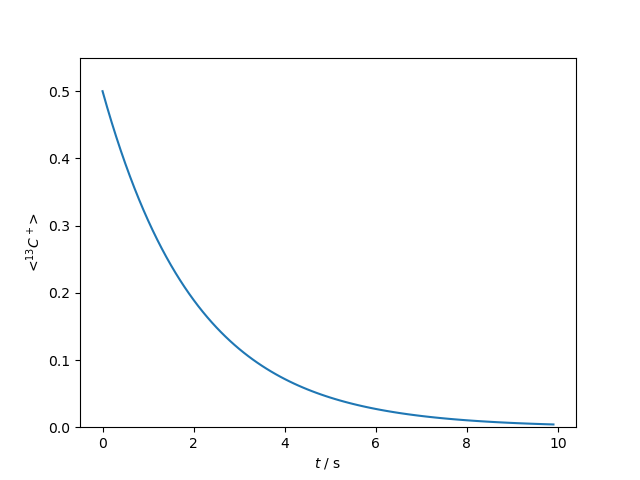

In [19]:
L.clear_relax()
L.add_relax(Type='T2',i=1,T2=5e-13)
U=L.U(Dt=0.1)
rho=RS.Rho(rho0='13Cx',detect='13Cp')
rho.DetProp(U,n=100)
ax=rho.plot(mode='abs',axis='s')
_=ax.set_ylim([0,.55])

Next, we check the dependence on electron $T_2$, where we again expect the maximum to occur at $1/\omega_{0,e}$, or ~400 fs

<IPython.core.display.Javascript object>


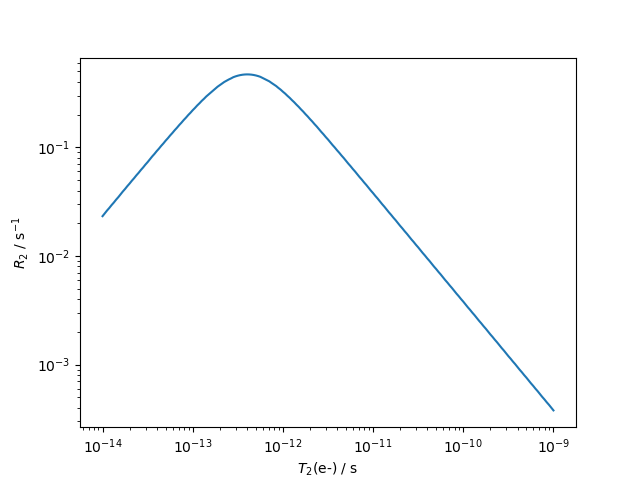

In [29]:
T20=np.logspace(-14,-9,201)
    
Dt=2/aiso    
N=200000
R2=list()
rho=RS.Rho(rho0='13Cx',detect='13Cp')
for k,T2 in enumerate(T20):
    rho.clear()
    L.clear_relax()
    L.add_relax(Type='T2',i=1,T2=T2)
    U=L.U(Dt=2/aiso)**N
    rho.DetProp(U,n=4000)
    rho.downmix()
    
    i0=np.abs(rho.I[0])<0.45
    if np.any(i0):
        i=np.argwhere(i0)[0,0]
        N=max(1,int(rho.t_axis[i]/(2/aiso)/10))
    else:
        i=3999
        N*=10
    R2.append((0.5-np.abs(rho.I[0][i]))/rho.t_axis[i]*2)

ax=plt.subplots(1,1)[1]
ax.loglog(T20,np.array(R2))
ax.set_xlabel(r'$T_2$(e-) / s')
_=ax.set_ylabel(r'$R_2$ / s$^{-1}$')

### Relaxation induced by electron $T_1$ relaxation
In this section, we'll add $T_1$ relaxation in addition to $T_2$ relaxation. The following will yield a warning since we include electron $T_1$ relaxation without electron $T_2$ relaxation

/Users/albertsmith/Documents/GitHub/SLEEPY/Liouvillian.py:324: UserWarning: T1 relaxation included without T2 relaxation. Unphysical system
  warnings.warn('T1 relaxation included without T2 relaxation. Unphysical system')


<IPython.core.display.Javascript object>


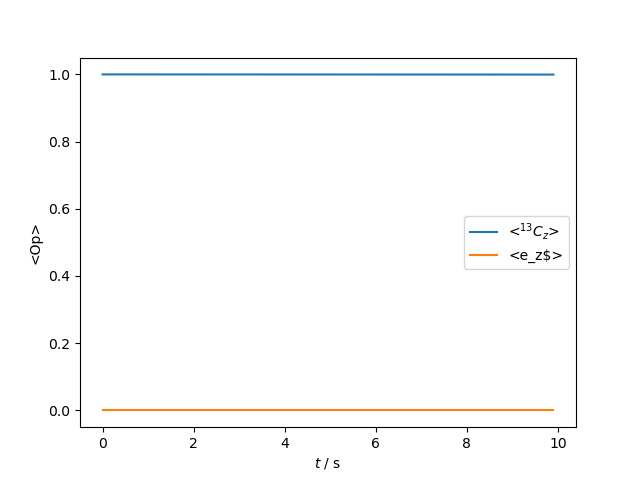

In [14]:
L.clear_relax()
L.add_relax(Type='T1',i=1,T1=1e-12)
U=L.U(Dt=0.1)

rho=RS.Rho(rho0='13Cz',detect=['13Cz','ez'])
rho.DetProp(U,n=100)
_=rho.plot(axis='s')

Above, we see that the relaxation without and with $T_1$ relaxation of the electron are nearly identical (I'm not sure why they're slightly different). This is to be expected: $T_1$ only modulates the term $S_zI_z$, which commutes with the longitudinal terms:
\begin{eqnarray}
\left[T_{00},\left[-\frac1{\sqrt3}I_zS_z,I_z\right]\right]&=&0 \\
\left[T_{00},\left[-\frac1{\sqrt3}I_zS_z,S_z\right]\right]&=&0
\end{eqnarray}
On the other hand, the commutator:
\begin{eqnarray}
\left[T_{00},\left[-\frac1{\sqrt3}I_zS_z,I^+\right]\right]&=&\frac1{12}(I^+-S^+) \\
\end{eqnarray}
suggests that the electron $T_1$ should induce significant transverse relaxation on the nucleus. As before, we will calculate without and with electron $T_1$ for comparison 

/Users/albertsmith/Documents/GitHub/pyRelaxSim/Liouvillian.py:324: UserWarning: T1 relaxation included without T2 relaxation. Unphysical system
  warnings.warn('T1 relaxation included without T2 relaxation. Unphysical system')


<IPython.core.display.Javascript object>


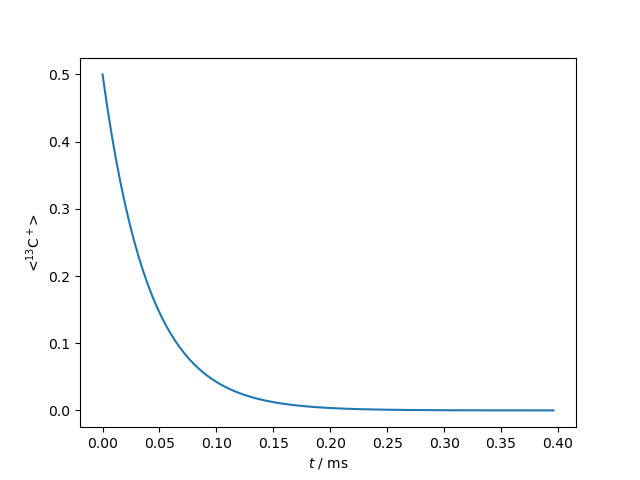

In [35]:
L.clear_relax()
# L.add_relax(Type='T2',i=1,T2=1e-14)
L.add_relax(Type='T1',i=1,T1=1e-8)
U=L.U(Dt=2/5e5)
rho.clear()
rho.DetProp(U,n=100)
_=rho.plot(mode='abs')

Next, we investigate the correlation time dependence, which should obey the following formulas:
\begin{eqnarray}
\Gamma_{I^+,I^+}^{(IS)}&=&\frac{S(S+1)}{6}(2\pi J^{(IS)})(J_0^Z(0)+J_0^X(\omega_I-\omega_S)) \\
\Gamma_{S^+,I^+}^{(IS)}&=&-\frac{S(S+1)}{6}(2\pi J^{(IS)})(J_0^Z(0)+J_0^X(\omega_I-\omega_S))
\end{eqnarray}

<IPython.core.display.Javascript object>


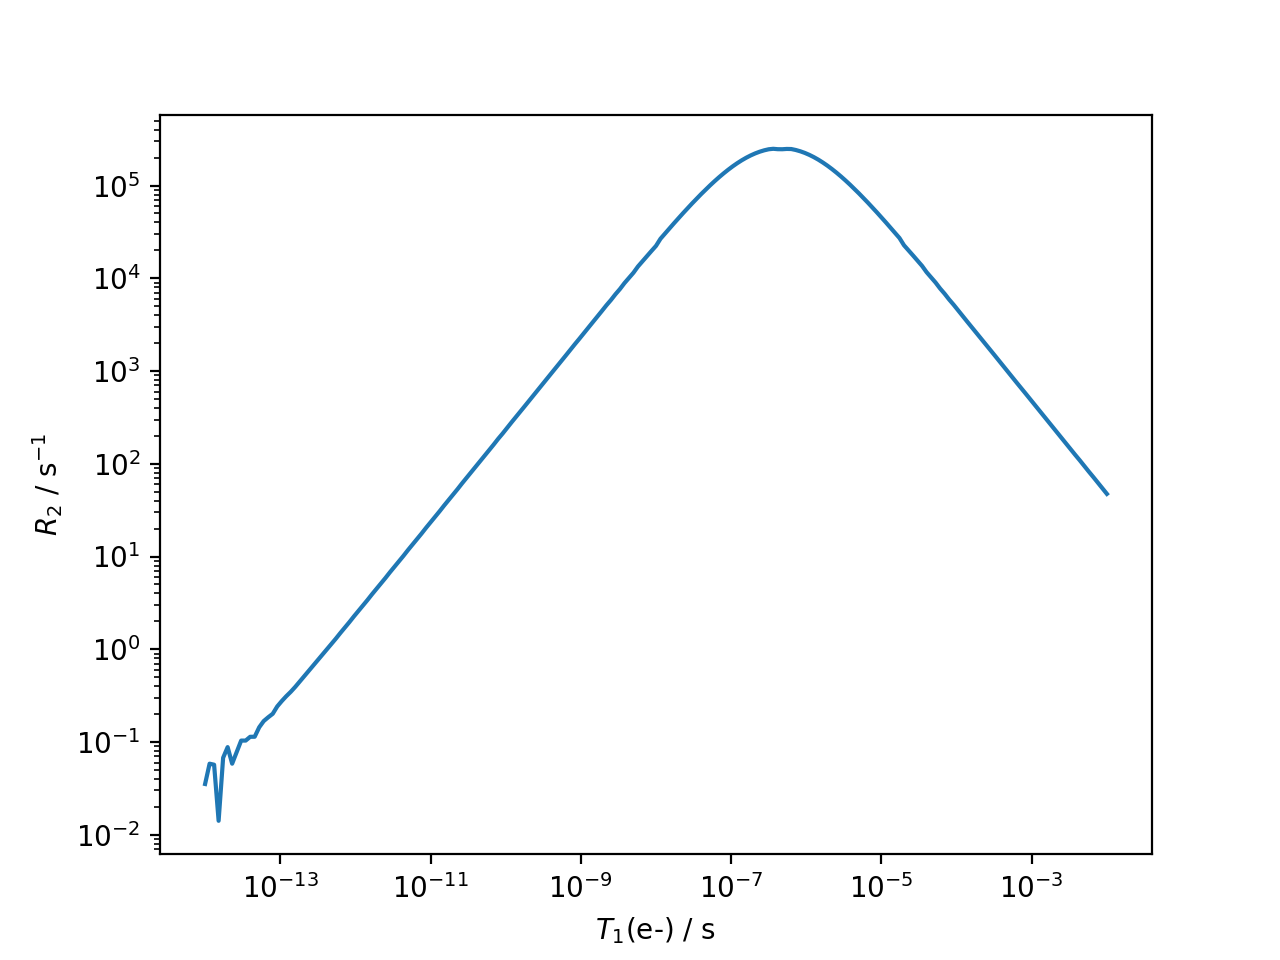

In [197]:
T10=np.logspace(-14,-2,201)
    
Dt=2/aiso    
N=70000
R2=list()
rho=RS.Rho(rho0='13Cx',detect='13Cp')
for k,T1 in enumerate(T10):
    rho.clear()
    L.clear_relax()
    L.add_relax(Type='T2',i=1,T2=1e-14)
    L.add_relax(Type='T1',i=1,T1=T1)
    U=L.U(Dt=2/aiso)**N
    rho.DetProp(U,n=4000)
    rho.downmix()
    
    i0=np.abs(rho.I[0])<0.45
    if np.any(i0):
        i=np.argwhere(i0)[0,0]
        N=max(1,int(rho.t_axis[i]/(2/aiso)/10))
    else:
        i=3999
        N*=10
    R2.append((0.5-np.abs(rho.I[0][i]))/rho.t_axis[i]*2)
    
ax=plt.subplots(1,1)[1]
ax.loglog(T10,np.array(R2))
ax.set_xlabel(r'$T_1$(e-) / s')
_=ax.set_ylabel(r'$R_2$ / s$^{-1}$')

Electron $T_1$ only affects the term $J_2^Z(0)$, so relaxation rates increase up until the electron $T_1$ is a similar order of magnitude to the hyperfine coupling.

## Part 3: Combined Influence of Exchange and Electron Relaxation

In the following, we see how the combination of exchange processes and electron relaxation can impact the nuclear relaxation

In [3]:
ex0=RS.ExpSys(v0H=600,Nucs=['13C','e'],LF=True)     #1-spin system at 600 MHz (14.1 T). LF=True : Lab Frame
ex1=ex0.copy()
aiso=5e4
ex0.set_inter(Type='hyperfine',i0=0,i1=1,Axx=aiso,Ayy=aiso,Azz=aiso)    #Hyperfine coupling
ex1.set_inter(Type='hyperfine',i0=0,i1=1,Axx=-aiso,Ayy=-aiso,Azz=-aiso)    #Hyperfine coupling

<IPython.core.display.Javascript object>


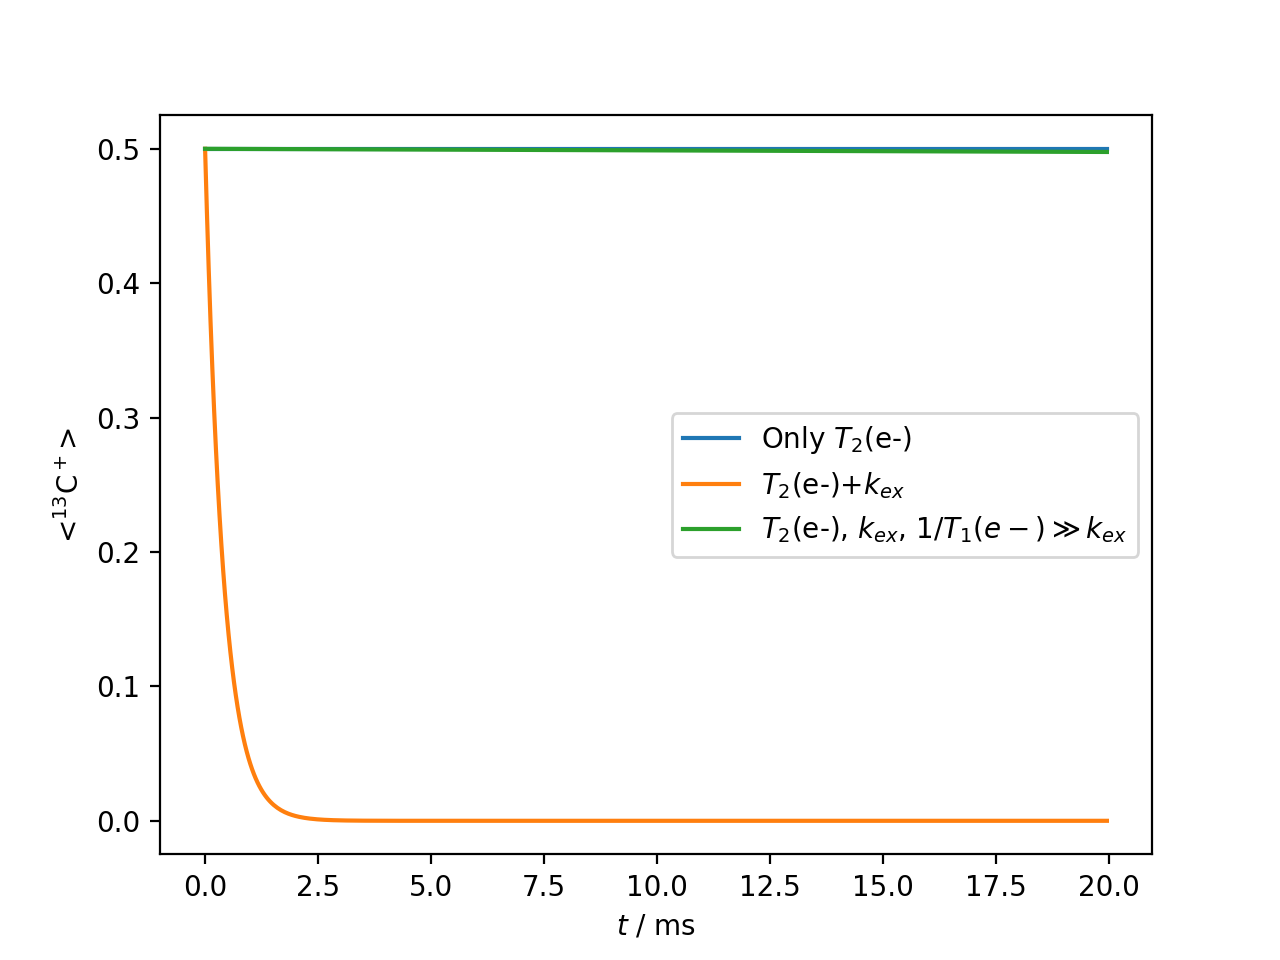

T2 ~ 426.5 microseconds


In [6]:
L=RS.Liouvillian((ex0,ex1))
L.add_relax(Type='T2',i=1,T2=1e-14)

U=L.U(Dt=2/aiso)
ax=plt.subplots(1,1)[1]

rho=RS.Rho(rho0='13Cx',detect='13Cp')
rho.DetProp(U,n=500)
rho.downmix()
_=rho.plot(ax=ax)

L.kex=RS.Tools.twoSite_kex(tc=1e-7)
U=L.U(Dt=2/aiso)

rho.clear()
rho.DetProp(U,n=500)
rho.downmix()
_=rho.plot(ax=ax)

print(f'T2 ~ {1/((0.5-rho.I[0,1].real)/rho.t_axis[1]*2)*1e6:.1f} microseconds')

L.add_relax(Type='T1',i=1,T1=1e-11)
U=L.U(Dt=2/aiso)

rho.clear()
rho.DetProp(U,n=500)
rho.downmix()
_=rho.plot(ax=ax)

ax.legend((r'Only $T_2$(e-)',r'$T_2$(e-)+$k_{ex}$',r'$T_2$(e-), $k_{ex}$, $1/T_{1}(e-)\gg k_{ex}$'))

In the above example, the first calculation only includes electron $T_2$ and exchange, which at the set correlation times, leads to almost no relaxation. However, when the exchange is adjusted to a faster correlation time, its influence becomes most significant. Note, however, if we introduce $T_1$ relaxation of the electron, then the influence of exchange is almost entirely removed– the electron $T_1$ averages away the coupling such that exchange with the same parameters no longer matters.

However, this is not an entirely realistic picture. If we consider the net polarization of the electron, then the $T_1$ averaging still yields a reduced hyperfine coupling and exchange still has some influence. We include recovery of the electron to thermal equilibrium with the option 

    L.add_relax('recovery')

<IPython.core.display.Javascript object>


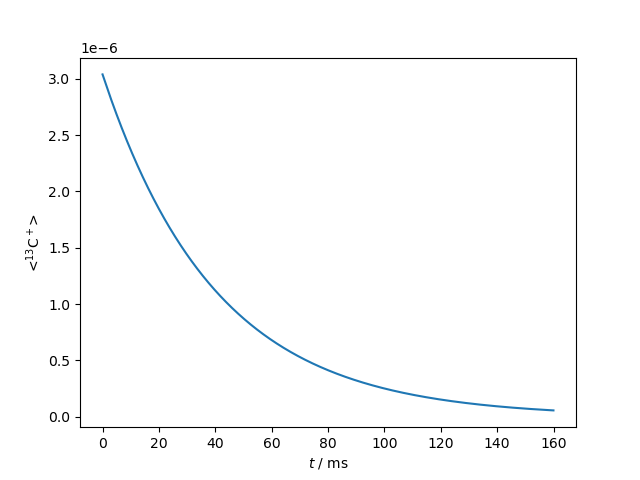

T2 ~ 41.1 milliseconds


In [58]:
L=RS.Liouvillian((ex0,ex1))
L.kex=RS.Tools.twoSite_kex(tc=1e-6)

L.clear_relax()
L.add_relax(Type='T2',i=1,T2=1e-14)
L.add_relax(Type='T1',i=1,T1=1e-12)
L.add_relax(Type='recovery')
U=L.U(Dt=2/aiso)

rho.clear()
rho.DetProp(U,n=4000)
rho.downmix()
rho.plot(mode='abs')
print(f'T2 ~ {1/((rho.I[0,0].real-rho.I[0,1].real)/rho.t_axis[1]/rho.I[0,0].real)*1000:.1f} milliseconds')


Then, the thermal polarization of the electron re-introduces some of the relaxation via the isotropic hyperfine coupling. The fraction of the original relaxation is given by the reduced size of the hyperfine, then is proportional to the electron polarization. Calculating from the electron polarization, we expect a reduction of roughly ~1000. This what we have actually observed.

In [30]:
print(f'Relaxation should be reduced by a factor of {L.expsys.Peq[1]**2:.4f}')

Relaxation should be reduced by a factor of 0.0010


<IPython.core.display.Javascript object>


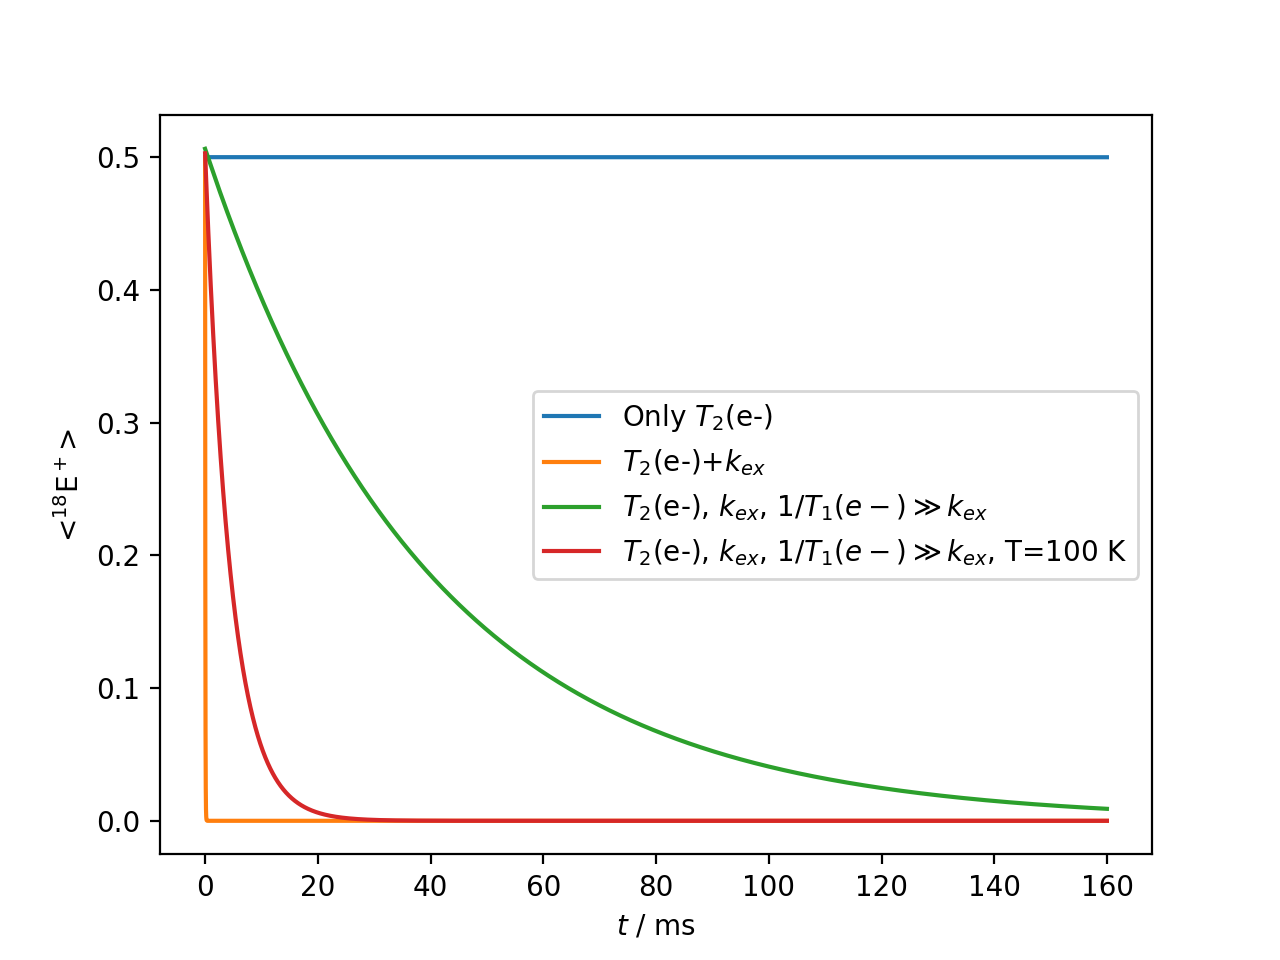

T2 ~ 63.8 microseconds


In [7]:
L=RS.Liouvillian((ex0,ex1))
L.expsys.T_K=298
L.add_relax(Type='T2',i=1,T2=1e-14)

U=L.U(Dt=2/aiso)
ax=plt.subplots(1,1)[1]

rho=RS.Rho(rho0='13Cx',detect='13Cp')
rho.DetProp(U,n=4000)
rho.downmix()
_=rho.plot(ax=ax)

L.kex=RS.Tools.twoSite_kex(tc=1e-6)
U=L.U(Dt=2/aiso)

rho.clear()
rho.DetProp(U,n=4000)
rho.downmix()
_=rho.plot(ax=ax)

print(f'T2 ~ {1/((0.5-rho.I[0,1].real)/rho.t_axis[1]*2)*1e6:.1f} microseconds')

L.add_relax(Type='T1',i=1,T1=1e-11)
L.add_relax(Type='recovery')
U=L.U(Dt=2/aiso)

rho=RS.Rho(rho0='13Cx',detect='6e-6*13Cp')
rho.DetProp(U,n=4000)
rho.downmix()
_=rho.plot(ax=ax)



L.expsys.T_K=100
L.clear_relax()
L.add_relax(Type='T2',i=1,T2=1e-14)
L.add_relax(Type='T1',i=1,T1=1e-12)
L.add_relax(Type='recovery')
U=L.U(Dt=2/aiso)

rho=RS.Rho(rho0='13Cx',detect='18e-6*13Cp')
rho.DetProp(U,n=4000)
rho.downmix()
_=rho.plot(ax=ax)

ax.legend((r'Only $T_2$(e-)',r'$T_2$(e-)+$k_{ex}$',r'$T_2$(e-), $k_{ex}$, $1/T_{1}(e-)\gg k_{ex}$',
           r'$T_2$(e-), $k_{ex}$, $1/T_{1}(e-)\gg k_{ex}$, T=100 K'))

In [10]:
np.tanh(ex0.v0[1]*6.626e-34/1.38e-23/ex0.T_K/2)

-0.09452787471980771

In [9]:
ex0.Peq

array([ 3.62108403e-05, -9.44846994e-02])

In [11]:
ex0.T_K

100